In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import time
import torch
import pickle
import warnings
warnings.filterwarnings('ignore')
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
import pandas as pd
import glob
from pathlib import Path
import importlib
files = glob.glob("../metadrl/data/warm_idealGAS/*.csv")

df = pd.DataFrame()
for f in files:
    csv = pd.read_csv(f)
    # df = df.append(csv)
    df = pd.concat([df, csv])
    
data_ICF = df[['picket_powers','foot_powers','neutron_yield','RhoR']]
spec = importlib.util.spec_from_file_location("optimization_tools", "../metadrl/tools/optimization_tools.py")
OOT = importlib.util.module_from_spec(spec) # importing old optimization tools
spec.loader.exec_module(OOT) # import old optimization tools
data_idealGAS = OOT.simulation_data('../metadrl/data/warm_idealGAS')
data_supercycle = OOT.simulation_data('../metadrl/data/warm_supercycle')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
bounds = torch.stack([torch.tensor([0.5,0.5], dtype=dtype, device=device), torch.tensor([12,12],dtype=dtype,device=device)])

# 1. Problem definition
## features (dimensions)
1. Molarity of LiPF6, from 0.2 to 2.1 (M)
2. Mass fraction of Ethylene Carbonate (EC) cosolvents of all solvents, from 0.3 to 0.52
3. DMC/EMC cosolvents ratio. from 0 to 1. 0 is pure EMC, 1 is pure DMC.

## Objective
- Lithium-ion conductivity (mS/cm). Larger is better

In [2]:
from experiments.uroch_func import URoch
from CoExBO._prior import Uniform

path_data = "./experiments/AEM_training_data.csv"
path_prior = "./experiments/electrolyte_prior.pickle"
true_function = URoch(None, None)
domain = Uniform(true_function.bounds)

In [3]:
true_function.feature_names

['picket_powers', 'foot_powers']

In [4]:
true_function.bounds

tensor([[ 0.5000,  0.5000],
        [12.0000, 12.0000]], dtype=torch.float64)

## 2. Define experimental conditions
Next, we define the experimental conditions.<br>

In [5]:
n_iterations = 5      # number of iterations
n_init_obj = 5        # number of initial random samples for objective function
n_init_pref = 10     # number of initial random samples for preferential learning
seed = 0              # random seed
file_save_name = 'uroch.pickle' # file save name

In [6]:
from CoExBO._coexbo import CoExBO, CoExBOwithSimulation, StateManager
torch.manual_seed(seed)          # random seed

#synthetic preferred dataset
coexbo = CoExBO(domain, true_function, feature_names=["picket_powers","foot_powers"], noisy=False, explanation=True,)
dataset_obj, dataset_duel = coexbo.initial_sampling(n_init_obj, n_init_pref)

Epoch: 1/10
X0 (random): tensor([ 6.7102, 10.6259])
X1 (random): tensor([10.6347,  5.7816])
You chose X0
Epoch: 2/10
X0 (random): tensor([2.3756, 4.7423])
X1 (random): tensor([0.8622, 9.4676])
You chose X0
Epoch: 3/10
X0 (random): tensor([5.8287, 7.4305])
X1 (random): tensor([7.5453, 3.0539])
You chose X0
Epoch: 4/10
X0 (random): tensor([10.0855,  2.1737])
X1 (random): tensor([5.7725, 6.7400])
You chose X0
Epoch: 5/10
X0 (random): tensor([11.1969,  7.9952])
X1 (random): tensor([2.5333, 8.7207])
You chose X1
Epoch: 6/10
X0 (random): tensor([3.9986, 1.6622])
X1 (random): tensor([9.3400, 0.7334])
You chose X1
Epoch: 7/10
X0 (random): tensor([ 1.3420, 10.4712])
X1 (random): tensor([ 4.0961, 11.7432])
You chose X1
Epoch: 8/10
X0 (random): tensor([8.4625, 4.9447])
X1 (random): tensor([8.8341, 3.7559])
You chose X0
Epoch: 9/10
X0 (random): tensor([8.2090, 6.8673])
X1 (random): tensor([3.7485, 1.4299])
You chose X0
Epoch: 10/10
X0 (random): tensor([0.8772, 2.7789])
X1 (random): tensor([7.7709,

In [7]:
dataset_obj

(tensor([[ 5.9637,  7.3140],
         [ 7.1558,  0.9269],
         [11.4327, 10.4170],
         [ 1.8853,  3.5066],
         [ 2.9719, 11.7031]], dtype=torch.float64),
 tensor([1.2824, 0.6834, 1.0869, 1.5175, 1.4492], dtype=torch.float64))

In [8]:
state = StateManager(n_dims=2)   # state parameter manager

In [6]:
from CoExBO._coexbo import CoExBO, StateManager

#>>> initial setting
torch.manual_seed(seed)          # random seed
state = StateManager(n_dims=3)   # state parameter manager
coexbo = CoExBO(
    domain,                      # domain
    true_function,               # true function (In reality, we run physical experiments.)
    true_function.feature_names, # feature names
    noisy=True,                  # Is observation noisy?
    explanation=True,
)
dataset_duel = true_function.prior_duel

# Initial run
X = coexbo.domain.sample(n_init_obj)
Y, Y_true = coexbo.true_function(X.squeeze())
dataset_obj = (X, Y, Y_true)

# 3. Collaborative Experiments!

### Rules
- You will get the pair of points (X0, X1).
- X0 is generated by the preference-based model.
- X1 is generated by the standard UCB. Namely, normal BO.
- You need to answer which you think larger.
- Type "0" if you think f_true(X0) > f_true(X1).
- Otherwise type "1".
- If you are unsure, type "2". Then, X1 is selected but it makes preference model remain unsure at the given pairwise candidate location. 
- We will iterate this back and forth at $n_{iterations}$ times

### Role of explanations
- The explanation is for demystifying the GP acquisition process, rather than giving "oracle" explanation guiding to the true global optimum.
- As such, YOU need to know the blackbox function better than GP. You should keep in mind the explanation is just advice, and you need to select based on your internal belief.
- Note that the early-stage GP is unreliable. All explanation is based on GP, so the early-stage explanation is not a good adviser. It can be useful to rectify your over-trust over GP. 
- Conversely, the later round GP is reliable. You can use the explanation for fine-tune your understanding.

### Explanation features
- You can ask more information by answering "y" when system asked if you need more explanation. Otherwise type"n" so that you can skip the explanation.
- The first feature is the simple GP prediction. You can check how GP predictive mean, variance, and UCB are different for each candidate. In early stage, mean is just unreliable. Uncertainty will give insights how likely you can get the information.
- The second feature is the Shapley value. This gives the importance of input dimension to the prediction at the given candidate. This example, Branin function, is a uncorrelated dimensions so the two dimensions should be equal contribution. If the Shapley values give biased feature importance, GP is likely to be misspecified (particularly in the early stages.).
- The third feature is the visualisation of each candidate. It will automatically visualise the 2 dimensional plot of GP predictive mean and variance based on top 2 largest Shapley values. You can check the geographical relationship between the candidates and the best observed point.
- The fourth feature is the visualisation of preference-based GP predictive mean and variance. This is the mixture of human preference and surroagte GP model so it is not the pure preference-based plot.
- The last feature is the feeback of your selection. The post-hoc analysis on the probability of correct answer will be returned.

0) parameters: beta 5.657e-01 gamma 0.000e+00
training models...
generating candidates...
X0 (preference): tensor([2.3414, 3.6290])
X1 (normal UCB): tensor([1.8853, 3.5066])
Do you need more explanation on the two candidates?


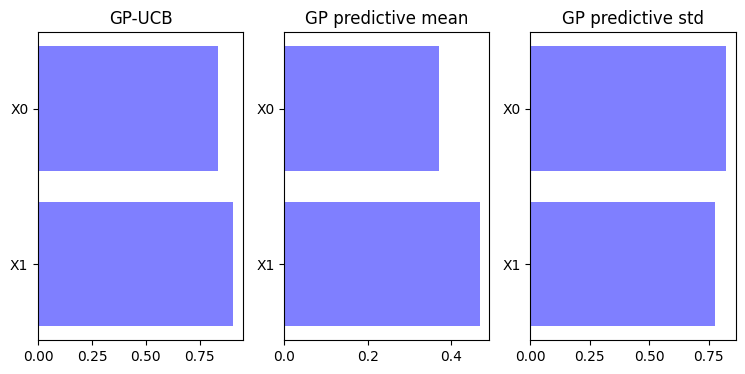

Do you want to know the attribution to each feature?


100%|██████████| 3/3 [00:00<00:00, 176.69it/s]


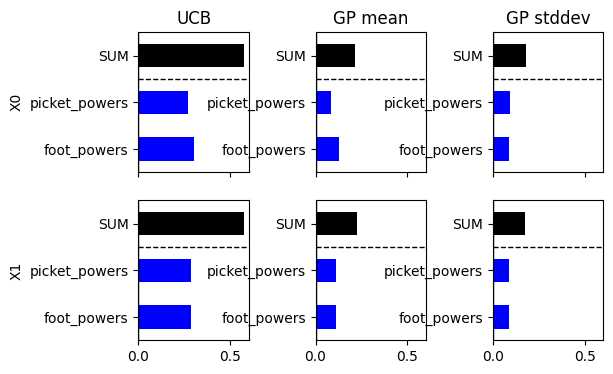

Do you want to visualise the GP on the plane where two candidates are placed?
Do you want to specify the dimension by yourself (y)? Otherwise, we estimate based on Shapley value (n)


100%|██████████| 3/3 [00:00<00:00, 4255.30it/s]


best observed, white dot o:tensor([1.8853, 3.5066], dtype=torch.float64)
X0 (preference), black star *:tensor([2.3414, 3.6290], dtype=torch.float64)
X1 (normal UCB), green cross +:tensor([1.8853, 3.5066], dtype=torch.float64)
observed points, yellow cross x


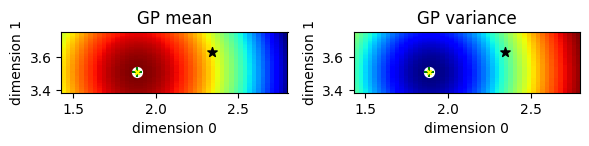

Do you want to visualise the learnt preference model on the plane where two candidates are placed?
Do you want to specify the dimension by yourself (y)? Otherwise, we estimate based on Shapley value (n)


100%|██████████| 3/3 [00:00<00:00, 4013.69it/s]


best observed, white dot o:tensor([1.8853, 3.5066], dtype=torch.float64)
X0 (preference), black star *:tensor([2.3414, 3.6290], dtype=torch.float64)
X1 (normal UCB), green cross +:tensor([1.8853, 3.5066], dtype=torch.float64)
observed points, yellow cross x


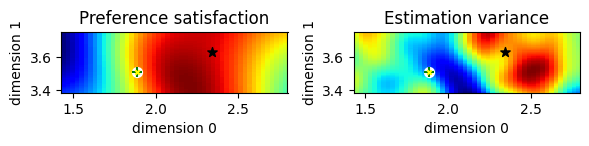

You chose X0
Probability of correct selection: 0.00e+00 ± 0.00e+00
Estimated total correct selection rate amongst sure samples: 4.62e-01 ± 9.63e-02
Is your selection correct? Yes if 1: 0.0
Is your selection sure? Yes if 1: 1
6) Best value: 1.51754e+00
1) parameters: beta 8.000e-01 gamma 1.000e-02
training models...
generating candidates...
X0 (preference): tensor([0.5000, 6.7023])
X1 (normal UCB): tensor([0.5000, 7.1305])
Do you need more explanation on the two candidates?


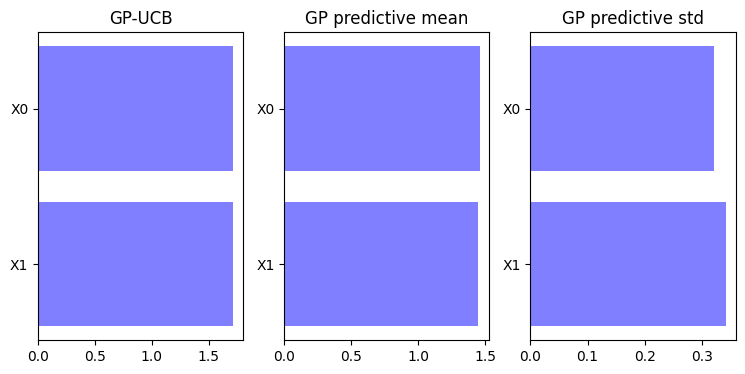

Do you want to know the attribution to each feature?


In [9]:
results = []
for t in range(n_iterations):
    beta, gamma = state(t)
    result, dataset_obj, dataset_duel = coexbo(
        dataset_obj, dataset_duel, beta, gamma,
    )
    print(f"{len(dataset_obj[0])}) Best value: {dataset_obj[1].max().item():.5e}")
    results.append(result)

results = torch.tensor(results)

all_results = (dataset_obj, dataset_duel, results)
with open(file_save_name, 'wb') as handle:
    pickle.dump(all_results, handle)

# Results
[overhead(s), best observation, Euclidean distance, correct answer, sure answer]

In [8]:
results

tensor([[55.6231, 16.8844,  0.5581,  1.0000,  1.0000],
        [21.5042, 16.8844,  0.8105,  1.0000,  1.0000],
        [18.6132, 16.8844,  1.0282,  1.0000,  1.0000],
        [16.4089, 18.0121,  0.7665,  1.0000,  1.0000],
        [20.2186, 18.0121,  1.1312,  1.0000,  1.0000]])